# Cryptocurrency Return Analysis

Let's see if there are any discernible trends in cryptocurrency returns after coins are first added to Coinbase 🤖

**In this notebook we will:**
- Get Tweets announcing new listings on Coinbase 
- Download cryptocurrency price data
- Analyse return trends after coin was listed on Coinbase

Emojis from: https://emojikeyboard.org/

In [1]:
import cryptocompare
import datetime as dt
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import twint 
import nest_asyncio

pd.set_option('max_colwidth', 400)

In [2]:
class CryptoDataExtractor:
    """
    A class to extract crypto price data from CryptoCompare
    """
    
    def __init__(self, coins=None, currency='GBP', exchange='Coinbase'):
        self.coins = coins
        self.currency = currency
        self.exchange = exchange
        
    def get_pairs(self, exchange='Coinbase'):
        """Get pairs available from a given exchange"""
        
        pairs_list = []
        pairs = cryptocompare.get_pairs(exchange=exchange)
        for pair in pairs:
            if pair['tsym'] == self.currency:
                pairs_list.append(pair['fsym'])

        self.coins = pairs_list
        
    def get_price_data(self, limit=2000, freq='daily', verbose=True):
        """Get price data"""
        
        if verbose:
            print('Downloading price data...')
            
        df = pd.DataFrame()

        _coins = self.coins.copy()
        
        for coin in _coins:
            if verbose:
                print(coin)
            first = True
            
            if freq == 'daily':
                recs = cryptocompare.get_historical_price_day(coin, self.currency, limit=limit, 
                                                              exchange=self.exchange, toTs=dt.datetime.now())
            elif freq == 'hourly':
                recs = cryptocompare.get_historical_price_hour(coin, self.currency, limit=limit, 
                                                               exchange=self.exchange, toTs=dt.datetime.now())
            else:
                raise ValueError(f'{freq} is not a valid frequency. Use either "daily" or "hourly"')
                
            price_list = []
            volume_list = []
            date_list = []
            
            if recs is not None:
                for rec in recs:    
                    if first:
                        date_list.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(rec['time'])))

                    price_list.append(rec['close'])
                    volume_list.append(rec['volumeto'] + 1e-6)

                df[coin] = price_list
                df[coin + '_vol'] = volume_list
                first = False
            else:
                print(f'Could not download data for {coin}')
                self.coins.remove(coin)
            
        df.index = date_list
        
        return df
    

In [3]:
# Helper functions
def plot(df, coins):
    """Plot returns"""

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Crypto Returns')
    for coin in coins:
        ax.plot(df[coin], label=coin)
    plt.legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), frameon=False)
    plt.show()


### 1.. Get twitter data 🔊
First let's download data from twitter using the twint library.

We will get all tweets from coinbase since 1st Jan 2019 that contain the text "now live".


In [4]:
nest_asyncio.apply()

def get_tweets(search, since, until, output=None, pandas_df=False, limit=None, username=None, verified=True, 
               hide_output=True, lang='en'):
    """
    Wrapper function to get tweets using the twint library
    """
    
    c = twint.Config()
    c.Search = search
    
    c.Since = since
    c.Until = until
    
    if limit is not None:
        c.Limit = limit
    
    if username is not None:
        c.Username = username
        
    c.Verified = verified
    c.Hide_output = hide_output
    c.Lang = lang
    c.Lower_case = True
    c.Count = True
    
    if output is not None:
        c.Store_csv = True
        c.Custom_csv = ['id', 'user_id', 'username', 'tweet']
        c.Output = output

    c.Pandas = pandas_df   
    
    # run search
    twint.run.Search(c)
    
    df = twint.storage.panda.Tweets_df
    
    if pandas_df:
        return twint.storage.panda.Tweets_df


In [5]:
# Get Twitter data from coinbase from when coins went live
search = 'now live' 
since = '2019-01-01'
until = '2021-12-31'
username = 'coinbase'

tweets_df = get_tweets(search, since, until, username = username, pandas_df=True, hide_output=True)
tweets_df = tweets_df[['date', 'tweet']]

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 35 Tweets from @coinbase.


In [6]:
def extract_symbol(string):
    """
    Extract coin symbol from a tweet string
    """
    
    string = string.replace(' is ', '')
    string = string.replace(' are ', '')
    string = string.replace(' and ', ', ')
    string = string.replace(' &amp; ', ', ') 
    string = string.replace('Orchid (OXT)', 'OXT') 
    string = string.replace('Tezos (XTZ)', 'XTZ') 
    string = string.replace(',', ' ')
    
    return string


In [7]:
# Get the coin symbols from the tweets data
dates_list = tweets_df['date'].to_list()
tweets_list = tweets_df['tweet'].to_list()
tweets_list = [x.split('now live')[0] for x in tweets_list]
tweets_list = [extract_symbol(x) for x in tweets_list]
tweets_list = [x.split() for x in tweets_list]

In [8]:
# Match coins with the dates that they were listed on Coinbase
listing_date_dict = {}

for i in range(len(dates_list)):
    if len(tweets_list[i]) < 5: # Crude way of getting rid of career tweet that made it through
        for coin in tweets_list[i]:
            listing_date_dict[coin] = dates_list[i]
            
# These are the coins that have been listed since 01 Jan 2019 on Coinbase
coins = list(listing_date_dict.keys())

# Check the dictionary
listing_date_dict

{'FORTH': '2021-04-21 23:05:31',
 '1INCH': '2021-04-09 21:07:03',
 'ENJ': '2021-04-09 21:07:03',
 'NKN': '2021-04-09 21:07:03',
 'OGN': '2021-04-09 21:07:03',
 'ANKR': '2021-03-25 20:07:52',
 'CRV': '2021-03-25 20:07:52',
 'STORJ': '2021-03-25 20:07:52',
 'ADA': '2021-03-19 18:06:07',
 'MATIC': '2021-03-11 21:09:12',
 'SKL': '2021-03-11 21:09:12',
 'SUSHI': '2021-03-11 21:09:12',
 'GRT': '2020-12-18 00:11:33',
 'AAVE': '2020-12-15 22:27:45',
 'BNT': '2020-12-15 22:27:45',
 'SNX': '2020-12-15 22:27:45',
 'FIL': '2020-12-10 18:43:59',
 'NU': '2020-12-03 19:01:24',
 'CVC': '2020-11-05 19:05:05',
 'MANA': '2020-11-05 19:05:05',
 'DNT': '2020-11-05 19:05:05',
 'WBTC': '2020-10-21 18:47:12',
 'REN': '2020-10-07 18:48:16',
 'BAL': '2020-10-07 18:48:03',
 'UNI': '2020-09-18 00:13:19',
 'YFI': '2020-09-17 18:50:11',
 'LRC': '2020-09-17 18:49:55',
 'UMA': '2020-09-10 18:48:10',
 'CGLD': '2020-09-03 18:45:47',
 'NMR': '2020-08-20 18:46:44',
 'BAND': '2020-08-13 18:45:19',
 'COMP': '2020-06-25 18:

### 2. Get crypto price data 📈
Get the price data for all the coins identified in part 1.

In [9]:
# Create new instance of CryptoDataExtractor and find GBP pairs
cc = CryptoDataExtractor(coins=coins, currency='USD')

# Get the price data
prices_df = cc.get_price_data(freq='daily')
prices_df.reset_index(inplace=True)
prices_df.rename(columns={'index':'date'}, inplace=True)

FORTH
1INCH
ENJ
NKN
OGN
ANKR
CRV
STORJ
ADA
MATIC
SKL
SUSHI
GRT
AAVE
BNT
SNX
FIL
NU
CVC
[ERROR] e param is not valid the market does not exist for this coin pair
Could not download data for CVC
MANA
DNT
[ERROR] e param is not valid the market does not exist for this coin pair
Could not download data for DNT
WBTC
REN
BAL
UNI
YFI
LRC
UMA
CGLD
NMR
BAND
COMP
MKR
OMG
KNC
ATOM
OXT
DASH
XTZ
LINK
EOS
DAI
REP
XLM
XRP


In [10]:
# Check the data
prices_df.head()

,date,FORTH,FORTH_vol,1INCH,1INCH_vol,ENJ,ENJ_vol,NKN,NKN_vol,OGN,...,EOS,EOS_vol,DAI,DAI_vol,REP,REP_vol,XLM,XLM_vol,XRP,XRP_vol
0,2015-11-03 00:00:00,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,...,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001
1,2015-11-04 00:00:00,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,...,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001
2,2015-11-05 00:00:00,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,...,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001
3,2015-11-06 00:00:00,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,...,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001
4,2015-11-07 00:00:00,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,...,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001,0.0,0.000001


### 3. Analyse returns 🚀
Now let's analyse returns for the following 30 days after a coin is listed on Coinbase.

In [11]:
# Get slices for each coin
n_periods = 30

slice_df = pd.DataFrame()
for coin in cc.coins:
    date = listing_date_dict[coin]
    coin_slice = prices_df[prices_df['date']>date][['date', coin]][:n_periods]
    coin_slice.reset_index(drop=True, inplace=True)
    if coin_slice.shape[0] == n_periods and coin_slice[coin][0] > 0.0:
        slice_df[coin] = coin_slice[coin]/coin_slice[coin][0]
        
# Add the mean price change
slice_df['mean'] = slice_df.mean(axis=1)

In [12]:
# Check the data
slice_df.head()

,ANKR,CRV,STORJ,ADA,MATIC,SKL,SUSHI,GRT,AAVE,BNT,...,MKR,OMG,KNC,ATOM,DASH,XTZ,EOS,REP,XRP,mean
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.437265,1.187976,2.054707,0.989176,1.024102,0.939590,1.176622,1.557576,0.971152,0.930157,...,0.931625,1.037611,1.220199,0.925230,0.959988,0.969993,0.898348,1.035112,0.994288,1.061355
2,1.250939,1.151065,1.722010,0.918401,0.918776,0.923722,1.064882,0.986834,1.036032,0.913185,...,0.864652,0.851770,1.483011,0.902039,0.938379,0.962317,0.901256,1.014981,0.982228,1.010444
3,1.239669,1.342466,1.741730,0.930891,0.942155,0.843817,1.019053,1.141275,1.014025,0.894256,...,0.931726,0.954093,1.322320,0.899840,0.894851,0.952547,0.777041,0.981273,0.956204,1.014470
4,1.241923,1.252664,1.886768,0.888426,0.902868,0.793381,1.042225,0.859143,0.977993,0.851828,...,0.913871,0.914270,1.244603,0.928029,0.745244,0.874389,0.731449,1.070693,0.996826,0.973100


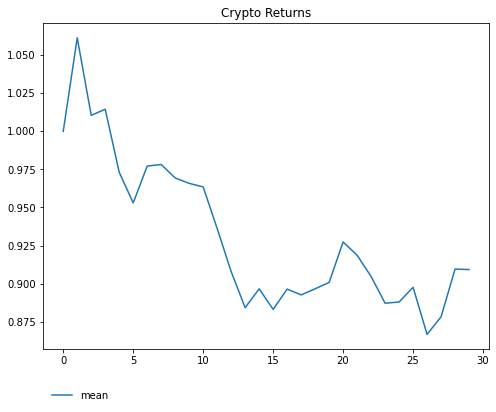

In [13]:
# Plot the mean price change
plot(slice_df, ['mean'])

Overall it looks like prices decrease on average after listing on Coinbase. Cryptocurrency returns are volatile and we should always be aware of this when conducting analysis. Outliers can skew our results greatly.

There appears to be a spike in returns the first day after listing. Let's look at the summary statistics of this data point to get a better intuition of what's going on.

In [26]:
# Get summary stats for the first day after listing
slice_df.drop('mean', axis=1).iloc[1, :].describe()

count    26.000000
mean      1.008280
std       0.139005
min       0.822095
25%       0.932847
50%       0.993628
75%       1.029154
max       1.557576
Name: 1, dtype: float64

The median index value is 1, which represents a 0% return, hence we can conclude that the mean is driven by outliers in the data.

For completeness let's have a look at returns across all the coins:

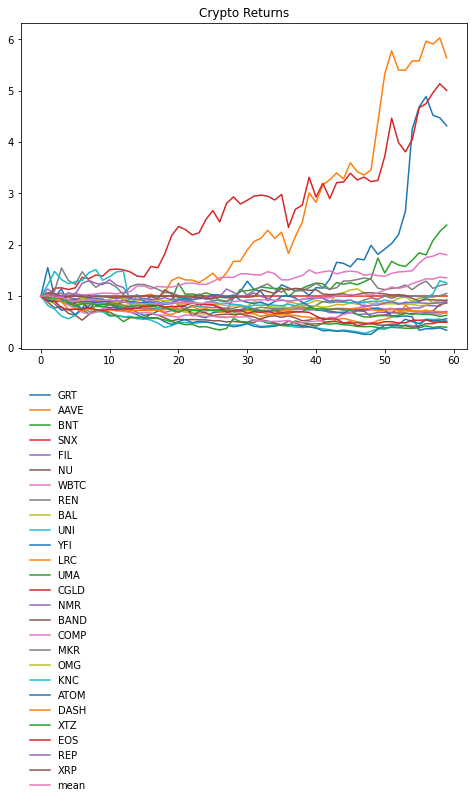

In [28]:
# Plot the data
plot(slice_df, slice_df.columns.tolist())